# Homework 1

<img src="./files/svm.png">

Try to generate datasets like this, fit SVM on each of them and find best regularization parameter and best kernel for each (use CV).

Dataset settings
- 2 features
- not more than 10k points
- you can either try generating from distributions, and maybe removing some elements after 
- or you can just generate by some functions, this would be easier, but it is OK

In [1]:
from sklearn.datasets import make_blobs
from matplotlib import pyplot
import pandas as pd
import numpy as np
from sklearn.svm import SVC

(1000, 2)
(1000,)


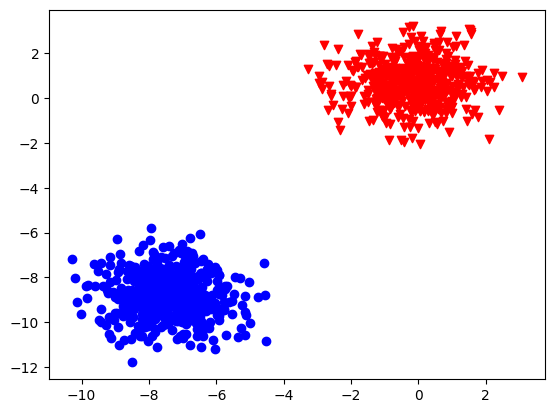

In [2]:
# generate 2d classification dataset
X, y = make_blobs(n_samples=1000, centers=2, n_features=2, random_state=2234)
print(X.shape)
print(y.shape)
# scatter plot, dots colored by class value
df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
X = df.drop(columns=['label'])
y = df['label']
pyplot.scatter(X['x'][y==0],X['y'][y==0],c='red', marker='v')
pyplot.scatter(X['x'][y==1],X['y'][y==1],c='blue', marker='o')
pyplot.show()

In [19]:
clf = SVC(kernel='linear')
clf.fit(X, y)

SVC(kernel='linear')

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
y_pred = clf.predict(X)

accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
print('accuracy',accuracy)
print('precision',precision)
print('recall',recall)
print('f1',f1)

accuracy 1.0
precision 1.0
recall 1.0
f1 1.0


In [21]:
w = clf.coef_[0]
print(w)
b = clf.intercept_
print(clf.intercept_)


[-0.18543559 -0.26663509]
[-1.81035082]


In [22]:
clf.n_features_in_

2

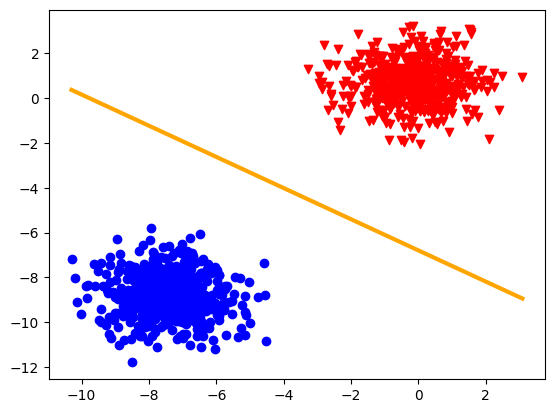

In [15]:

x = np.linspace(np.min(X['x']), np.max(X['x']))
y = df['label']
pyplot.scatter(X['x'][y==0],X['y'][y==0],c='red', marker='v')
pyplot.scatter(X['x'][y==1],X['y'][y==1],c='blue', marker='o')

pyplot.plot(x, -x*w[0]/w[1]  - b/w[1], color='orange', linewidth=3, )

pyplot.show()

# Homework 2ravel

Write a function is_kernel_function(func), which will return True if given function is a kernel function and False if it is not.

In [ ]:
def is_kernel_function(func):
    # 
    return True

    #
    return False